In [1]:
import numpy as np
  
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, multiply, Lambda, add, Activation
from keras.layers import concatenate
from keras.optimizers import *
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.preprocessing import image
import keras
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix 
from sklearn.model_selection import KFold

import os
from os import listdir

import natsort  
import pandas as pd

import datetime
now = datetime.datetime.now
import cv2

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
img_row = 256
img_col = 256
img_chan = 1
epochnum = 200
batchnum = 4 

**Load Data**


In [4]:
image_path = '/content/drive/MyDrive/CV-project/images/'
masks_path = '/content/drive/MyDrive/CV-project/masks/'
saliency_path = '/content/drive/MyDrive/CV-project/saliency/'

In [25]:
image_loc = listdir(image_path)
mask_loc = listdir(masks_path)
sal_loc = listdir(saliency_path)
image_loc = natsort.natsorted(image_loc)
mask_loc = natsort.natsorted(mask_loc)
sal_loc = natsort.natsorted(sal_loc)
no_images = len(image_loc)

In [26]:
def img_load(directory, imgs_list):
    img_array = []
    for i in range(no_images):
        tmp_img = cv2.imread(os.path.join(directory, imgs_list[i]))
        tmp_img = cv2.cvtColor(tmp_img, cv2.COLOR_BGR2GRAY)
        tmp_img = cv2.resize(tmp_img, (256,256)) 
        tmp_img = tmp_img.astype('float32')/255
        tmp_img = tmp_img.reshape(256,256,1)
        img_array.append(tmp_img)
    
    img_array = np.asarray(img_array)
    return img_array    

    

In [27]:
print(image_loc[10],mask_loc[10],sal_loc[10])

000011.png 000011.png 000011.png


In [28]:
img_data = img_load(image_path,image_loc)
mask_data = img_load(masks_path,mask_loc)
map_data = img_load(saliency_path,sal_loc)

**Data Visualziation**

Text(0.5, 1.0, 'Map image')

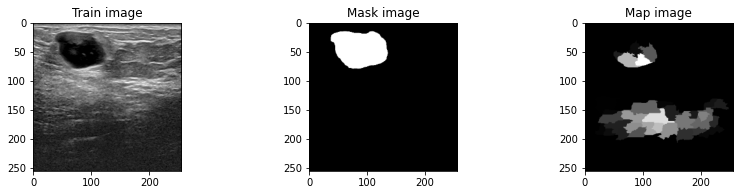

In [30]:
plt.figure(figsize = (14,6))
plt.subplot(231)
plt.imshow(np.squeeze(img_data[20]), cmap = "gray")
plt.title('Train image')
plt.subplot(232)
plt.imshow(np.squeeze(mask_data[20]), cmap = "gray")
plt.title('Mask image')
plt.subplot(233)
plt.imshow(np.squeeze(map_data[20]), cmap = "gray")
plt.title('Map image')

In [31]:
img_data.shape
mask_data.shape
map_data.shape

(163, 256, 256, 1)

**Performance Metrics**

In [32]:
def dice_coeff(y_true,y_pred):
    smoothener = 1.
    # masks
    y_true_flat = K.flatten(y_true)
    y_pred_flat = K.flatten(y_pred)
    overlap = K.sum(y_true_flat * y_pred_flat)
    score = (2 * overlap + smoothener) / (K.sum(y_true_flat) + K.sum(y_pred_flat) + smoothener) 
    return score

In [33]:
def dice_loss(y_true,y_pred):
    dice_loss = 1 - dice_coeff(y_true,y_pred)
    return dice_loss

In [34]:
def metrics(y_true,y_pred):
    smoothener = K.epsilon()
    y_pred_one = np.round(np.clip(y_pred,0,1))
    y_pred_zero = 1 -y_pred_one
    y_actual_one = np.round(np.clip(y_true,0,1))
    y_actual_zero = 1 -y_actual_one
    true_positive = np.sum(y_pred_one*y_actual_one)
    false_positive = np.sum(y_pred_one*y_actual_zero)
    true_negative = np.sum(y_pred_zero*y_actual_zero)
    false_negative = np.sum(y_pred_zero*y_actual_one)
    true_positive_rate = (true_positive + smoothener)/(true_positive + false_negative + smoothener)
    true_negative_rate = (true_negative + smoothener)/(true_positive + false_positive + smoothener)
    precision = (true_positive + smoothener)/(true_positive + false_positive + smoothener)*100
    recall = (true_positive+smoothener)/(true_positive + false_negative +smoothener)*100
    intersection_union = (true_positive + smoothener)/(true_positive + false_negative+false_positive+ smoothener)
    dice_coeff_ret = (2*true_positive + smoothener)/ (2*true_positive + false_negative + false_positive + smoothener)
    return (dice_coeff_ret,intersection_union,recall,precision)



**Custom Layers Functions**

In [35]:
def expand_tensor(tensor,rep):
    repeat = Lambda(lambda x , repnum: K.repeat_elements(x,repnum,axis=3),arguments = {'repnum':rep})(tensor)
    return repeat

In [36]:
def Salient_Block(feature_maps,salinecy_images,pool_layer,num_maps):
    convolution_saliency_1 = Conv2D(128,(1,1),activation='relu')(salinecy_images)
    convolution_feature_maps_1 = Conv2D(128,(1,1),strides=(2,2),activation='relu')(feature_maps)
    attention_addition = add([convolution_feature_maps_1,convolution_saliency_1])
    convolution_1_D = Conv2D(128, (3, 3), activation='relu', padding='same')(attention_addition)
    convolution_1_D = Conv2D(128, (3, 3), activation='relu', padding='same')(convolution_1_D)
    convolution_1_D = Conv2D(1, (1, 1), activation='relu')(convolution_1_D)
    convolution_1_D = expand_tensor(convolution_1_D,32)
    convolution_N_D = Conv2D(num_maps,(1,1),activation = 'relu')(convolution_1_D)
    attention_activation = Activation('sigmoid')(convolution_N_D)
    attention_b = multiply([attention_activation,pool_layer])
    return attention_b

In [37]:
def Unet_Block(input_maps,no_maps):
    conv_in = Conv2D(no_maps, (3, 3), activation='relu', padding='same')(input_maps)
    conv_out =Conv2D(no_maps,(3,3),activation = 'relu',padding='same')(conv_in)
    return conv_out

**Model**

In [38]:
def Model_SA_UNET(print_sum= False):
   input_layer_image = Input(shape= (256,256,1))

   convolution_1 = Unet_Block(input_layer_image,32)
   pooling_1 = MaxPooling2D(pool_size=(2,2))(convolution_1)

   input_layer_sa_maps = Input(shape= (256,256,1))

   downsample_1 = MaxPooling2D(2,2)(input_layer_sa_maps)
   attention_1 = Salient_Block(convolution_1,downsample_1,pooling_1,32)

   convolution_2 = Unet_Block(attention_1,32)
   pooling_2 = MaxPooling2D(pool_size=(2,2))(convolution_2)

   downsample_2 = MaxPooling2D(4,4)(input_layer_sa_maps)
   attention_2 = Salient_Block(convolution_2,downsample_2,pooling_2,32)

   convolution_3 = Unet_Block(attention_2,64)
   pooling_3 = MaxPooling2D(pool_size=(2,2))(convolution_3)

   downsample_3 = MaxPooling2D(8,8)(input_layer_sa_maps)
   attention_3 = Salient_Block(convolution_3,downsample_3,pooling_3,64)

   convolution_4 = Unet_Block(attention_3,64)
   pooling_4 = MaxPooling2D(pool_size=(2,2))(convolution_4)

   downsample_4 = MaxPooling2D(16,16)(input_layer_sa_maps)
   attention_4 = Salient_Block(convolution_4,downsample_4,pooling_4,64)

   convolution_5 = Unet_Block(attention_4,128)

   up_sample_6 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(convolution_5),attention_3], axis=3)
   convolution_6 = Unet_Block(up_sample_6,64)

   up_sample_7 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(convolution_6),attention_2], axis=3)
   convolution_7 = Unet_Block(up_sample_7,64)

   up_sample_8 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(convolution_7),attention_1], axis=3)
   convolution_8 = Unet_Block(up_sample_8,32)

   up_sample_9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(convolution_8),convolution_1], axis=3)
   convolution_9 = Unet_Block(up_sample_9,32)

   convolution_10 = Conv2D(1,(1,1),activation='sigmoid')(convolution_9)

   model = Model(inputs = [input_layer_image,input_layer_sa_maps],outputs= convolution_10)
   
   if  print_sum == True:  
       print(model.summary())
   
   return model





In [39]:
Model_SA_UNET(True)

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d_86 (Conv2D)              (None, 256, 256, 32) 320         input_5[0][0]                    
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d_87 (Conv2D)              (None, 256, 256, 32) 9248        conv2d_86[0][0]                  
_______________________________________________________________________________________

**Model Performance**

fOLD 1
Testing time: 0:00:00.471402
------------------------------
USING THRESHOLD 0.5

 DSC 		0.667 
 IOU 		0.578 
 Recall 	62.278 
 Precision	84.374


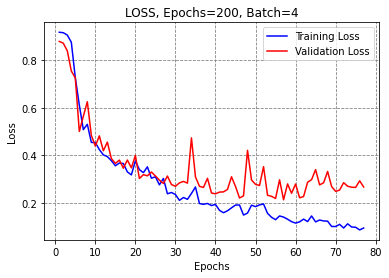

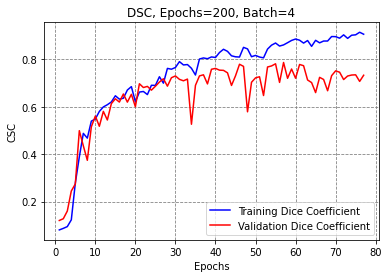

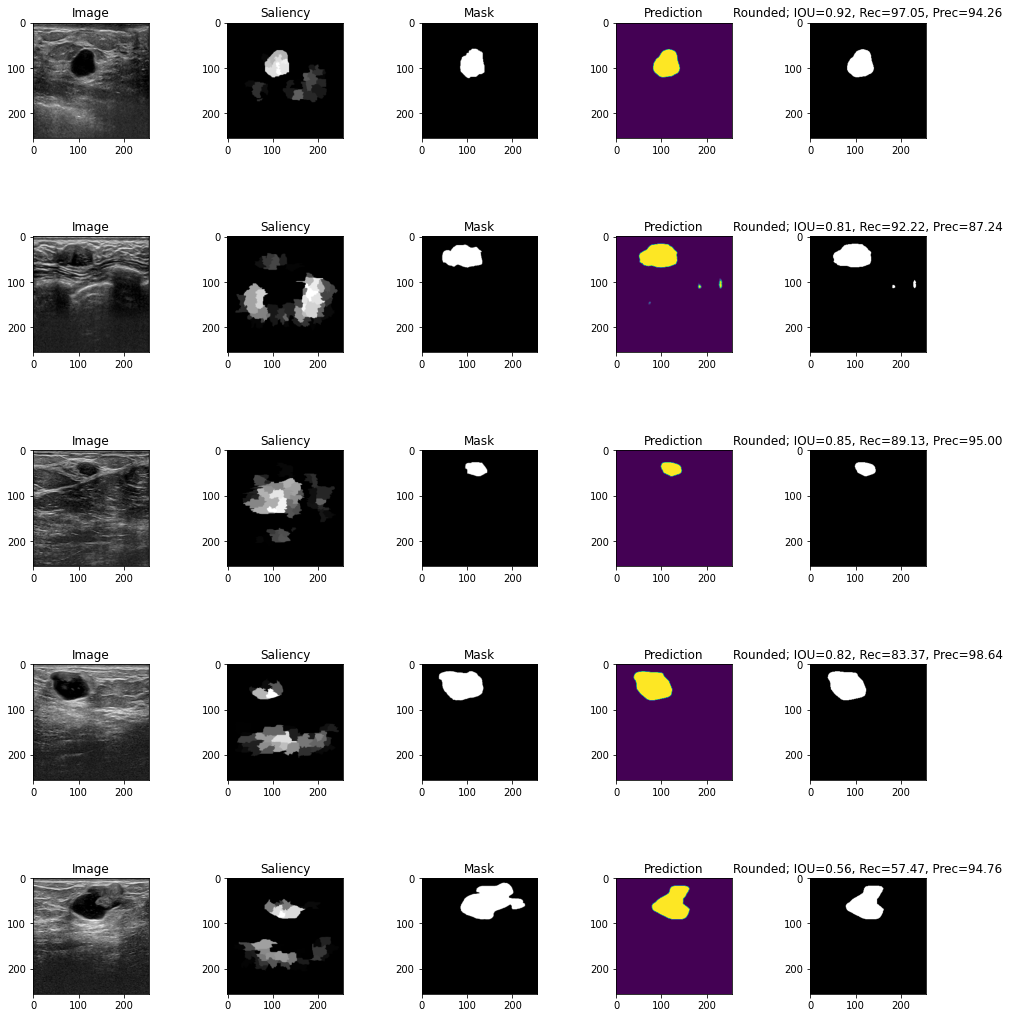

Global Accuracy: 0.9810522830847538
Global Accuracy: 0.9810522830847538

Area under the ROC curve: 0.9518956079134702
fOLD 2
Testing time: 0:00:00.492297
------------------------------
USING THRESHOLD 0.5

 DSC 		0.657 
 IOU 		0.556 
 Recall 	66.577 
 Precision	84.644


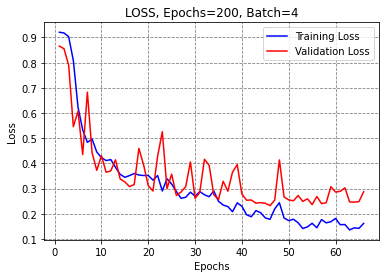

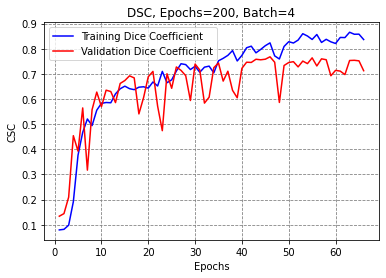

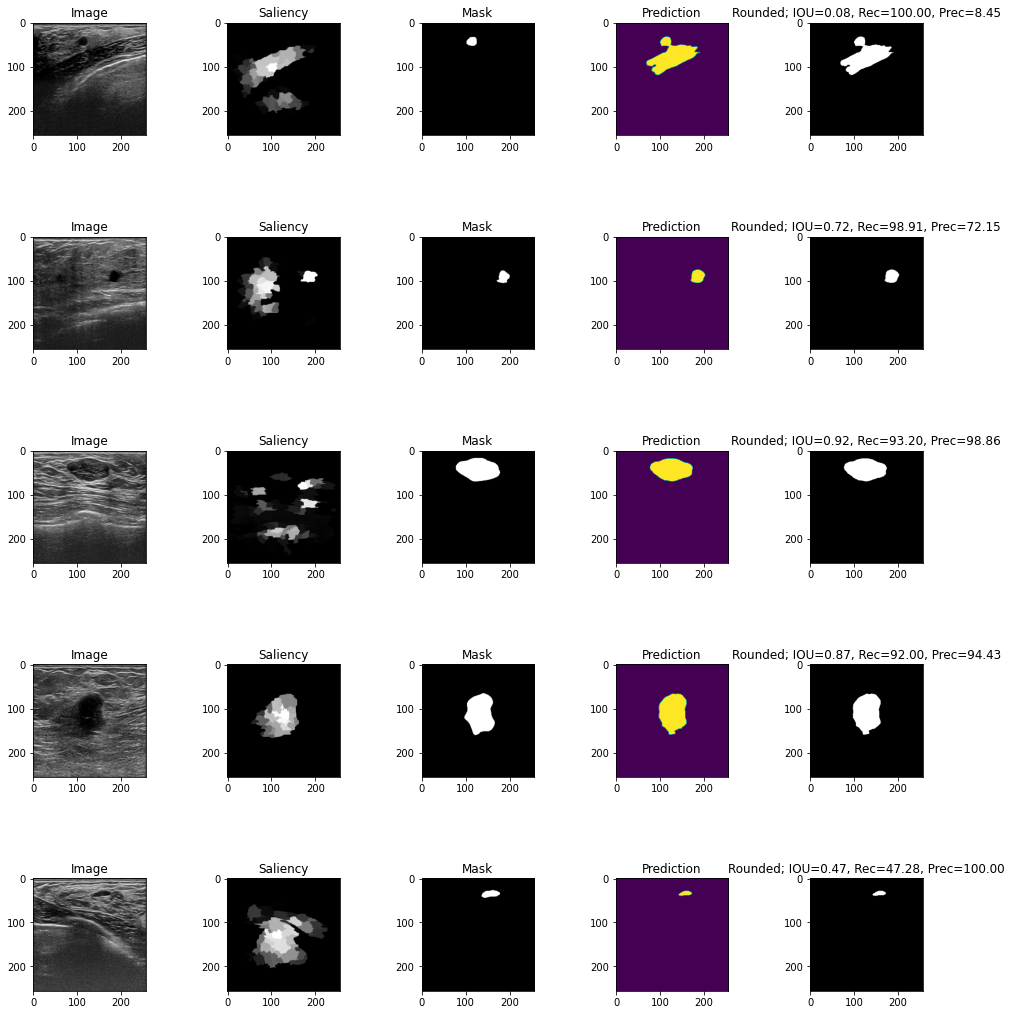

Global Accuracy: 0.9745779326467803
Global Accuracy: 0.9745779326467803

Area under the ROC curve: 0.8996270301364817
fOLD 3
Testing time: 0:00:00.947101
------------------------------
USING THRESHOLD 0.5

 DSC 		0.698 
 IOU 		0.588 
 Recall 	74.601 
 Precision	73.871


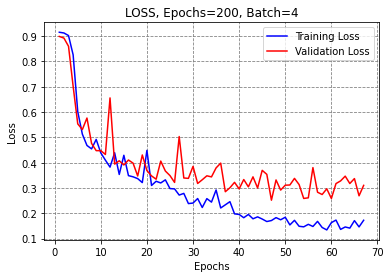

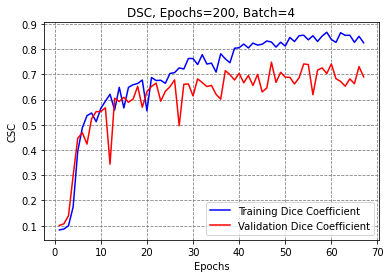

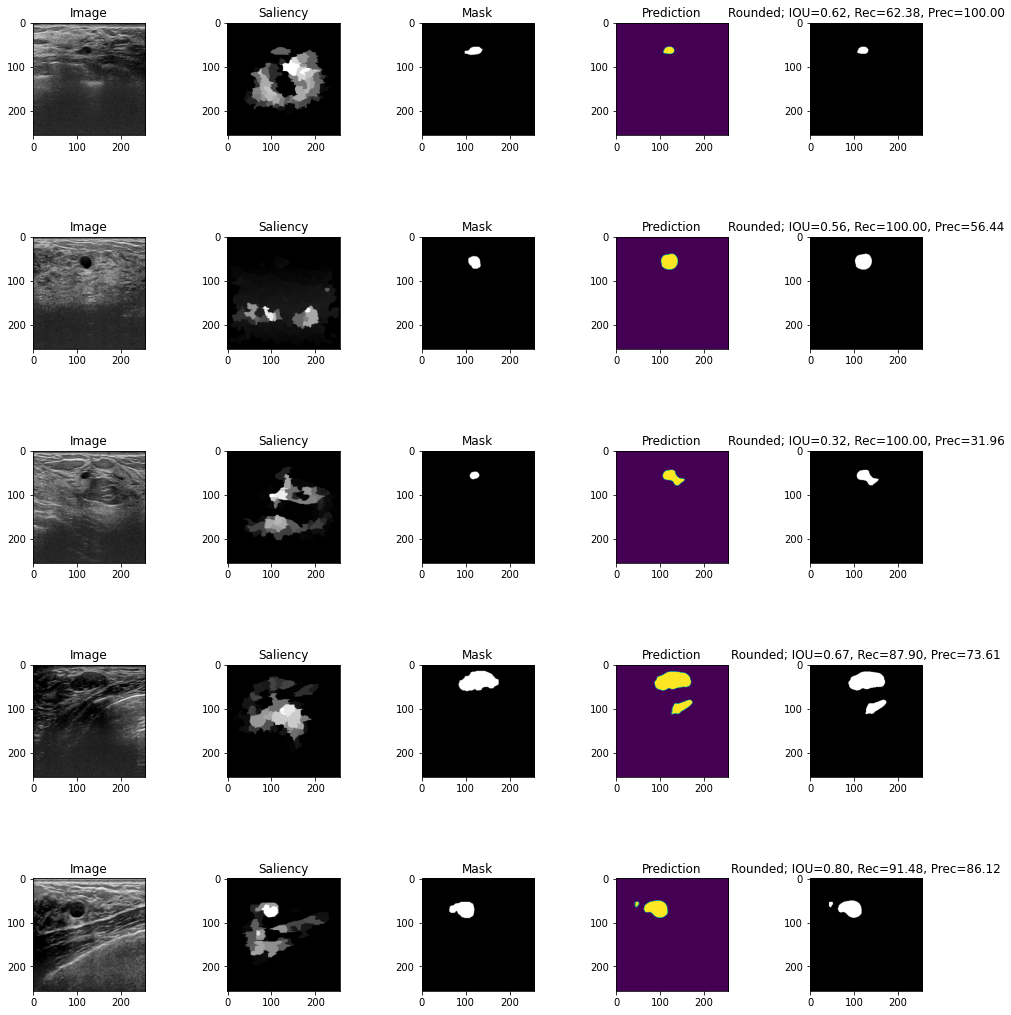

Global Accuracy: 0.9817740700461648
Global Accuracy: 0.9817740700461648

Area under the ROC curve: 0.9046245890902244
fOLD 4
Testing time: 0:00:00.461604
------------------------------
USING THRESHOLD 0.5

 DSC 		0.738 
 IOU 		0.636 
 Recall 	77.520 
 Precision	78.758


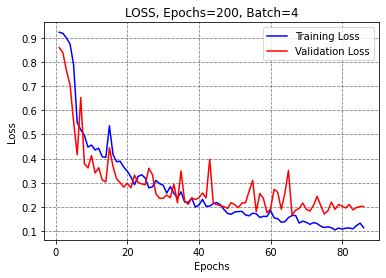

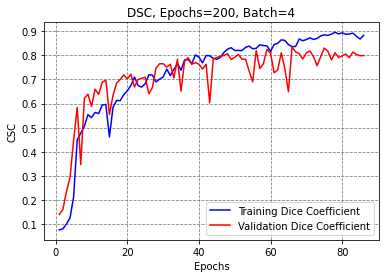

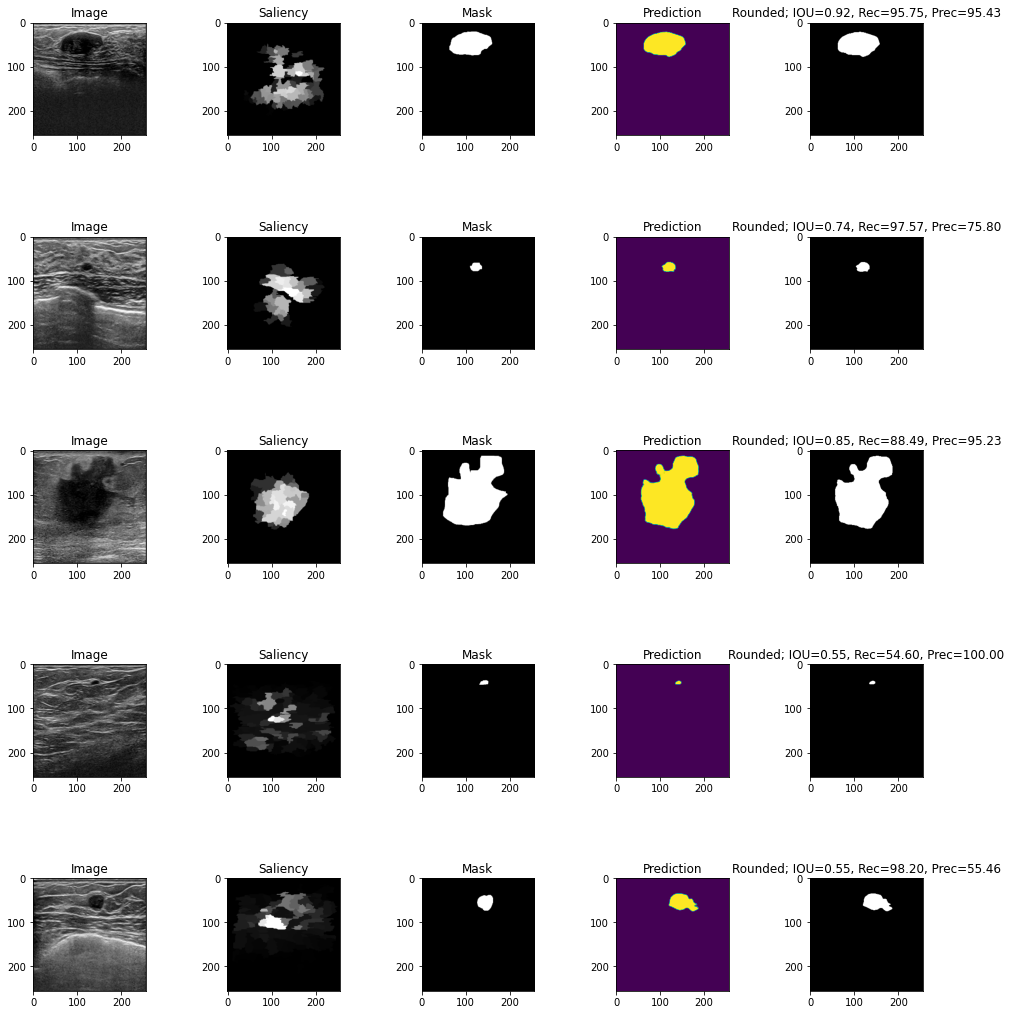

Global Accuracy: 0.9791698455810547
Global Accuracy: 0.9791698455810547

Area under the ROC curve: 0.9007500590955515
fOLD 5
Testing time: 0:00:00.466465
------------------------------
USING THRESHOLD 0.5

 DSC 		0.700 
 IOU 		0.598 
 Recall 	71.118 
 Precision	79.907


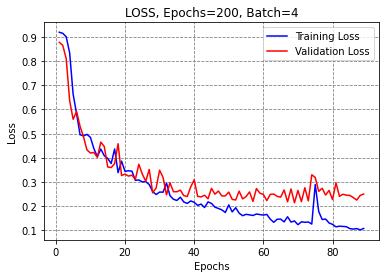

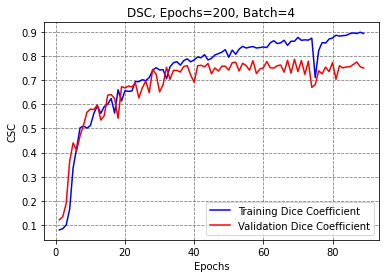

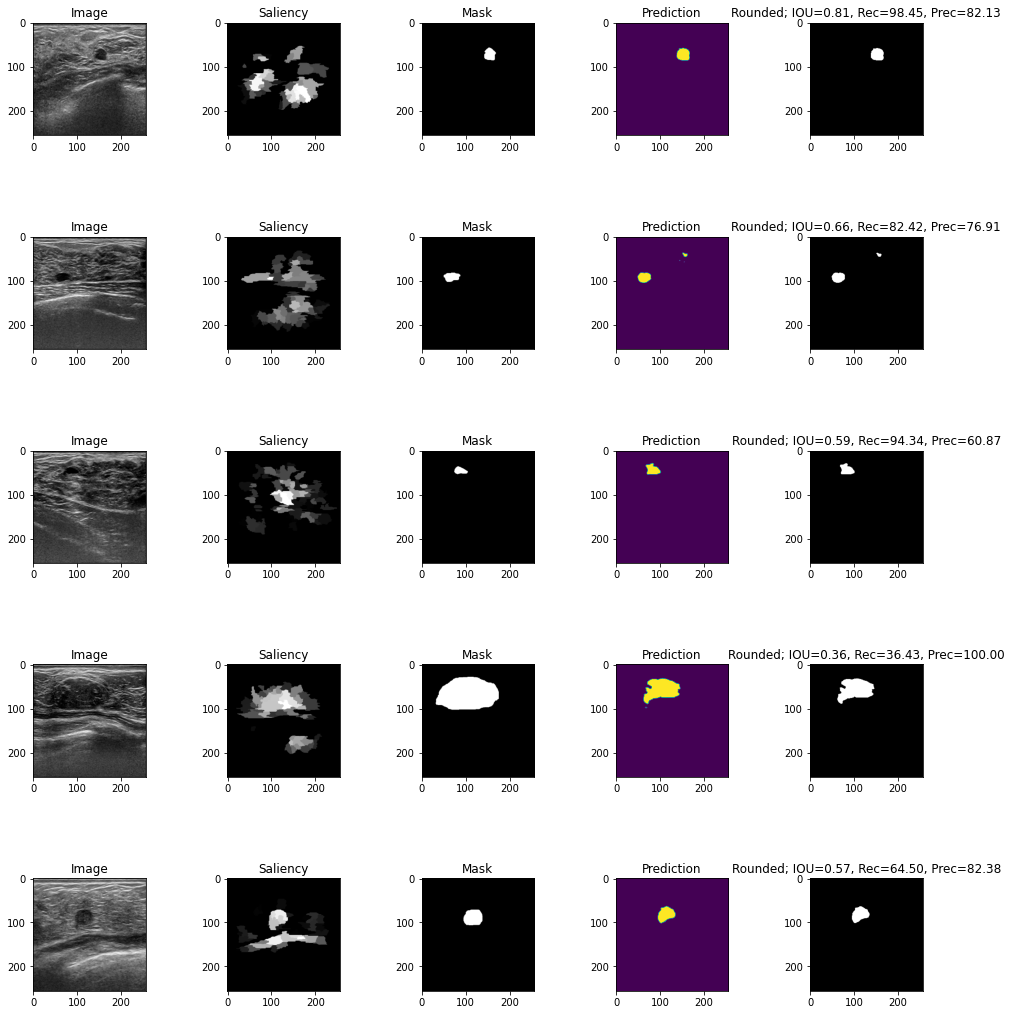

Global Accuracy: 0.9828286170959473
Global Accuracy: 0.9828286170959473

Area under the ROC curve: 0.9354622878700304


In [55]:
n_folds =5
kfold = KFold(n_splits= n_folds,shuffle=True,random_state =10)
numepochs = np.zeros(n_folds,)
dice_score = np.zeros(n_folds,)
iou_score = np.zeros(n_folds,)
rec_score = np.zeros(n_folds,)
prec_score = np.zeros(n_folds,)
globacc_score = np.zeros(n_folds,)
auc_roc_score = np.zeros(n_folds,)
run =0

for  train_index,test_index in kfold.split(img_data):
     print('fOLD',run +1)
     Model_eval = Model_SA_UNET()
     img_train, mask_train, sals_train, img_test, mask_test, sals_test = img_data[train_index], mask_data[train_index], map_data[train_index], img_data[test_index], mask_data[test_index], map_data[test_index]
     Model_eval.compile(optimizer= Adam(lr = 0.0001),loss=dice_loss,metrics=[dice_coeff])
     t = now()    
     callbacks = [EarlyStopping(monitor='val_loss', patience = 20)]
     history = Model_eval.fit([img_train, sals_train], mask_train, validation_split=0.15, batch_size=batchnum, 
                        epochs=epochnum, verbose=0, callbacks=callbacks)
         # PLot the loss and accuracy
     train_loss = history.history['loss']
     val_loss = history.history['val_loss']
     acc = history.history['dice_coeff'] 
     val_acc = history.history['val_dice_coeff']

     epochsn = np.arange(1, len(train_loss)+1,1)
     plt.plot(epochsn,train_loss, 'b', label='Training Loss')
     plt.plot(epochsn,val_loss, 'r', label='Validation Loss')
     plt.grid(color='gray', linestyle='--')
     plt.legend()
     plt.title('LOSS, Epochs={}, Batch={}'.format(epochnum, batchnum))
     plt.xlabel('Epochs')
     plt.ylabel('Loss')

     plt.figure()
     plt.plot(epochsn, acc, 'b', label='Training Dice Coefficient')
     plt.plot(epochsn, val_acc, 'r', label='Validation Dice Coefficient')
     plt.grid(color='gray', linestyle='--')
     plt.legend()            
     plt.title('DSC, Epochs={}, Batch={}'.format(epochnum, batchnum))
     plt.xlabel('Epochs')
     plt.ylabel('CSC')
    
      # Make predictions
     t = now()
     preds = Model_eval.predict([img_test, sals_test])
     print('Testing time: %s' % (now() - t))
    
    # Evaluate model
     num_test = len(img_test)
    # Calculate performance metrics
     dsc_sc = np.zeros((num_test,1))
     iou_sc = np.zeros_like(dsc_sc)
     rec_sc = np.zeros_like(dsc_sc)
     tn_sc = np.zeros_like(dsc_sc)
     prec_sc = np.zeros_like(dsc_sc)
     thresh = 0.5
     for i in range(num_test):
         temp_pred = (preds[i]>thresh)
         dsc_sc[i], iou_sc[i], rec_sc[i], prec_sc[i] = metrics(mask_test[i], temp_pred)
     print('-'*30)
     print('USING THRESHOLD', thresh)
     print('\n DSC \t\t{0:^.3f} \n IOU \t\t{1:^.3f} \n Recall \t{2:^.3f} \n Precision\t{3:^.3f}'.format(
            np.sum(dsc_sc)/num_test,  
            np.sum(iou_sc)/num_test,  
            np.sum(rec_sc)/num_test,
            np.sum(prec_sc)/num_test ))
    
    # Plot the predicted masks
     num_disp = 5
     j=1
     plt.figure(figsize = (14,num_disp*3))
     for i in range(num_disp):
         plt.subplot(num_disp,5,j)
         plt.imshow(np.squeeze(img_test[i]), cmap='gray')
         plt.title('Image')
         j +=1
         plt.subplot(num_disp,5,j)
         plt.imshow(np.squeeze(sals_test[i]),cmap='gray')
         plt.title('Saliency')
         j +=1
         plt.subplot(num_disp,5,j)
         plt.imshow(np.squeeze(mask_test[i]),cmap='gray')
         plt.title('Mask')
         j +=1
         plt.subplot(num_disp,5,j)
         plt.imshow(np.squeeze(preds[i]))
         plt.title('Prediction')
         j +=1
         plt.subplot(num_disp,5,j)
         plt.imshow(np.squeeze(np.round(preds[i])), cmap='gray')
         plt.title('Rounded; IOU=%0.2f, Rec=%0.2f, Prec=%0.2f' %(iou_sc[i], rec_sc[i], prec_sc[i]))
         j +=1
     plt.tight_layout()
     plt.show()    
    
    # confusion matrix
     confusion = confusion_matrix(mask_test.ravel().astype('uint8'),preds.ravel()>thresh)
     accuracy = 0
     if float(np.sum(confusion))!=0:
         accuracy = float(confusion[0,0]+confusion[1,1])/float(np.sum(confusion))
     print("Global Accuracy: " +str(accuracy))
    
    
    # Save outputs 
     if float(np.sum(confusion))!=0:
         accuracy = float(confusion[0,0]+confusion[1,1])/float(np.sum(confusion))
     print("Global Accuracy: " +str(accuracy))
    
    # Area under the ROC curve
     AUC_ROC = roc_auc_score(preds.ravel()>thresh, mask_test.ravel())
     print("\nArea under the ROC curve: " +str(AUC_ROC))
    
    # Save outputs 
     numepochs[run] = epochsn[-1]
     dice_score[run] = np.sum(dsc_sc)/num_test
     iou_score[run] = np.sum(iou_sc)/num_test
     rec_score[run] = np.sum(rec_sc)/num_test
     prec_score[run] = np.sum(prec_sc)/num_test
     globacc_score[run] = accuracy
     auc_roc_score[run] = AUC_ROC
     run +=1
    

**Final Metrics**

In [69]:
Results = pd.DataFrame({'Dice_score':dice_score,'IOU_Score':iou_score,'Recall':rec_score,'Precision':prec_score,'Global_Accuracy':globacc_score,'AOC_score':auc_roc_score})
Mean_results = Results.describe().reset_index()
Mean_results[Mean_results['index'] == 'mean'].iloc[:,1:7]

,Dice_score,IOU_Score,Recall,Precision,Global_Accuracy,AOC_score
1,0.692075,0.591017,70.418967,80.310967,0.979881,0.918472
